/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


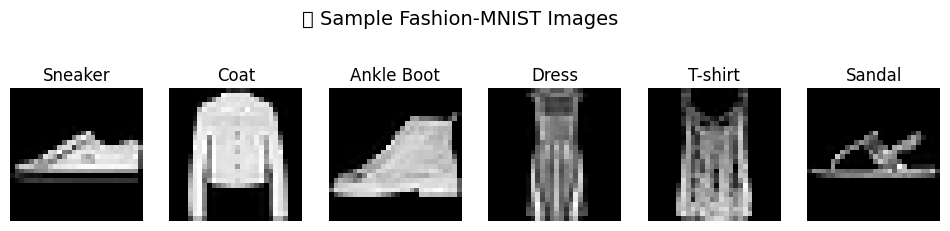


Training ANN Model...
Epoch [1/10] - Train Loss: 0.5944, Val Loss: 0.4310
Epoch [2/10] - Train Loss: 0.4494, Val Loss: 0.3926
Epoch [3/10] - Train Loss: 0.4162, Val Loss: 0.3582
Epoch [4/10] - Train Loss: 0.3867, Val Loss: 0.3504
Epoch [5/10] - Train Loss: 0.3710, Val Loss: 0.3571
Epoch [6/10] - Train Loss: 0.3573, Val Loss: 0.3255
Epoch [7/10] - Train Loss: 0.3474, Val Loss: 0.3385
Epoch [8/10] - Train Loss: 0.3379, Val Loss: 0.3306
Epoch [9/10] - Train Loss: 0.3321, Val Loss: 0.3242
Epoch [10/10] - Train Loss: 0.3272, Val Loss: 0.3083
Test Accuracy: 87.63%

Training CNN Model...
Epoch [1/10] - Train Loss: 0.4401, Val Loss: 0.2862
Epoch [2/10] - Train Loss: 0.2787, Val Loss: 0.2404
Epoch [3/10] - Train Loss: 0.2278, Val Loss: 0.2264
Epoch [4/10] - Train Loss: 0.1945, Val Loss: 0.2130
Epoch [5/10] - Train Loss: 0.1674, Val Loss: 0.2153
Epoch [6/10] - Train Loss: 0.1424, Val Loss: 0.2099
Epoch [7/10] - Train Loss: 0.1235, Val Loss: 0.2049
Epoch [8/10] - Train Loss: 0.1098, Val Loss: 0.

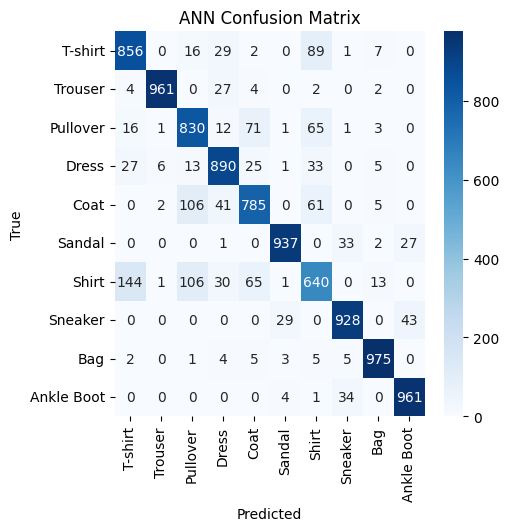


📊 CNN Confusion Matrix:


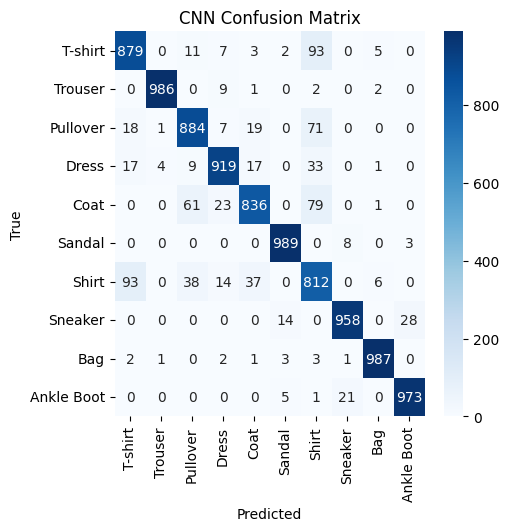


================= PERFORMANCE SUMMARY =================
ANN Test Accuracy: 87.63%
CNN Test Accuracy: 92.23%

CNN typically performs better because it captures spatial features (edges, textures, patterns),
while the ANN only sees flattened pixels without spatial context.
Common confusion often occurs between visually similar classes like 'Shirt' vs 'Coat'.
You can improve results further by:
 - Using Data Augmentation (rotation, flipping, etc.)
 - Adding Dropout or BatchNorm
 - Trying different optimizers (e.g., AdamW)
 - Increasing network depth or filters for CNNs


In [4]:
# ============================================================
# 📘 FASHION-MNIST CLASSIFICATION USING ANN & CNN (PyTorch)
# ============================================================

# ✅ Step 1: Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# ============================================================
# ✅ Step 2: Load and Preprocess Dataset
# ============================================================

# Transform: Normalize pixel values to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load Fashion-MNIST training and test datasets
train_dataset = datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform
)

# Split the training dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for batching and shuffling
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ============================================================
# ✅ Step 3: Visualize Sample Images
# ============================================================

labels_map = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

def show_samples(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    fig, axes = plt.subplots(1, 6, figsize=(12, 3))
    for i in range(6):
        img = images[i].squeeze()
        label = labels_map[labels[i].item()]
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(label)
        axes[i].axis('off')
    plt.suptitle("🔍 Sample Fashion-MNIST Images", fontsize=14)
    plt.show()

show_samples(train_loader)

# ============================================================
# ✅ Step 4: Define the Models
# ============================================================

# --- Model 1: Artificial Neural Network (ANN / MLP) ---
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


# --- Model 2: Convolutional Neural Network (CNN) ---
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)  # ✅ Fixed flatten size
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))  # Output: [batch, 64, 14, 14]
        x = self.dropout(x)
        x = x.view(x.size(0), -1)             # Flatten dynamically
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ============================================================
# ✅ Step 5: Training and Evaluation Functions
# ============================================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        train_losses.append(running_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses


def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return all_labels, all_preds, accuracy

# ============================================================
# ✅ Step 6: Train Both Models
# ============================================================

print("\nTraining ANN Model...")
ann_model = ANN()
ann_train_loss, ann_val_loss = train_model(ann_model, train_loader, val_loader, epochs=10)
ann_labels, ann_preds, ann_acc = test_model(ann_model, test_loader)

print("\nTraining CNN Model...")
cnn_model = CNN()
cnn_train_loss, cnn_val_loss = train_model(cnn_model, train_loader, val_loader, epochs=10)
cnn_labels, cnn_preds, cnn_acc = test_model(cnn_model, test_loader)

# ============================================================
# ✅ Step 7: Confusion Matrices
# ============================================================

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels_map, yticklabels=labels_map)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print("\n📊 ANN Confusion Matrix:")
plot_confusion(ann_labels, ann_preds, "ANN Confusion Matrix")

print("\n📊 CNN Confusion Matrix:")
plot_confusion(cnn_labels, cnn_preds, "CNN Confusion Matrix")

# ============================================================
# ✅ Step 8: Performance Comparison
# ============================================================

print("\n================= PERFORMANCE SUMMARY =================")
print(f"ANN Test Accuracy: {ann_acc:.2f}%")
print(f"CNN Test Accuracy: {cnn_acc:.2f}%")
print("\nCNN typically performs better because it captures spatial features (edges, textures, patterns),")
print("while the ANN only sees flattened pixels without spatial context.")
print("Common confusion often occurs between visually similar classes like 'Shirt' vs 'Coat'.")
print("You can improve results further by:")
print(" - Using Data Augmentation (rotation, flipping, etc.)")
print(" - Adding Dropout or BatchNorm")
print(" - Trying different optimizers (e.g., AdamW)")
print(" - Increasing network depth or filters for CNNs")


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


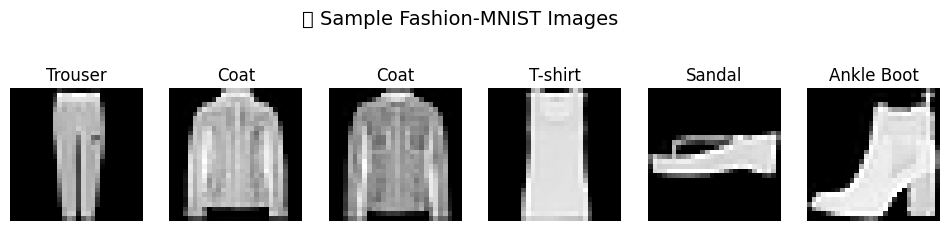


Training ANN Model...
Epoch [1/10] - Train Loss: 0.6009, Val Loss: 0.4309
Epoch [2/10] - Train Loss: 0.4505, Val Loss: 0.3839
Epoch [3/10] - Train Loss: 0.4141, Val Loss: 0.3647
Epoch [4/10] - Train Loss: 0.3939, Val Loss: 0.3581
Epoch [5/10] - Train Loss: 0.3780, Val Loss: 0.3406
Epoch [6/10] - Train Loss: 0.3617, Val Loss: 0.3332
Epoch [7/10] - Train Loss: 0.3511, Val Loss: 0.3262
Epoch [8/10] - Train Loss: 0.3416, Val Loss: 0.3248
Epoch [9/10] - Train Loss: 0.3326, Val Loss: 0.3362
Epoch [10/10] - Train Loss: 0.3256, Val Loss: 0.3138
Test Accuracy: 87.83%

Training CNN Model...
Epoch [1/10] - Train Loss: 0.4512, Val Loss: 0.2946
Epoch [2/10] - Train Loss: 0.2786, Val Loss: 0.2421
Epoch [3/10] - Train Loss: 0.2279, Val Loss: 0.2242
Epoch [4/10] - Train Loss: 0.1939, Val Loss: 0.2281
Epoch [5/10] - Train Loss: 0.1626, Val Loss: 0.2244
Epoch [6/10] - Train Loss: 0.1428, Val Loss: 0.2146
Epoch [7/10] - Train Loss: 0.1212, Val Loss: 0.2317
Epoch [8/10] - Train Loss: 0.1085, Val Loss: 0.

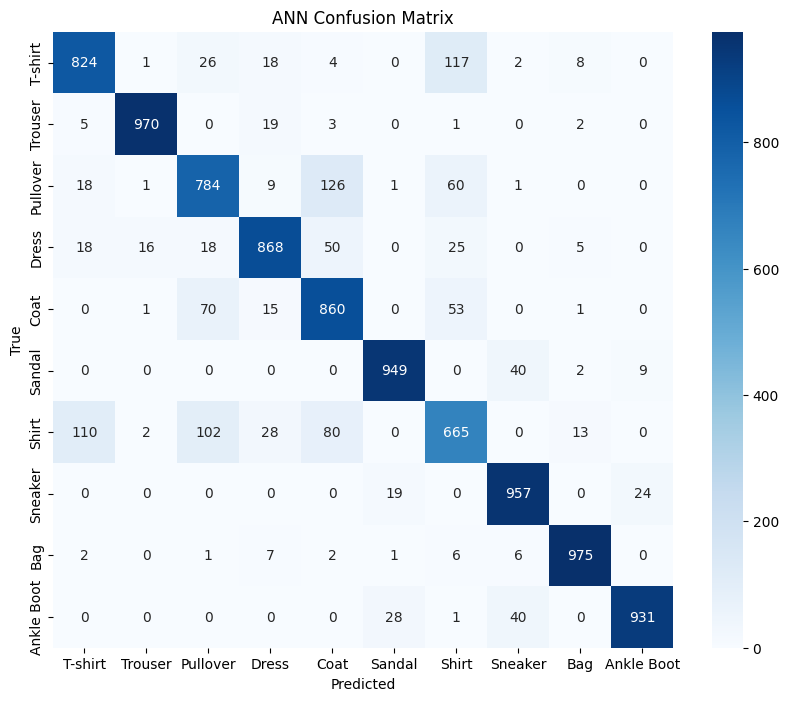


📊 CNN Confusion Matrix:


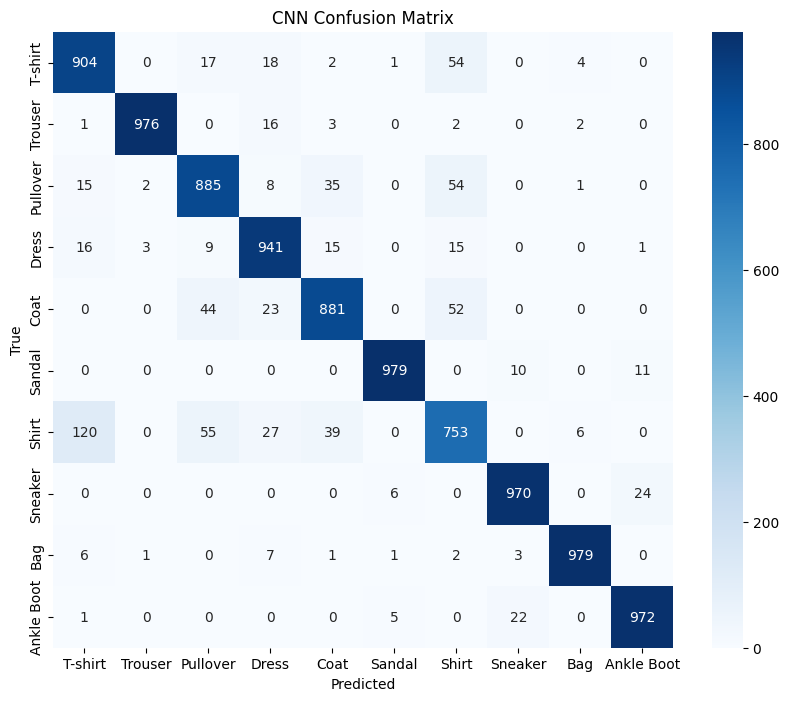

/tmp/ipython-input-3112125290.py:215: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='coolwarm')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


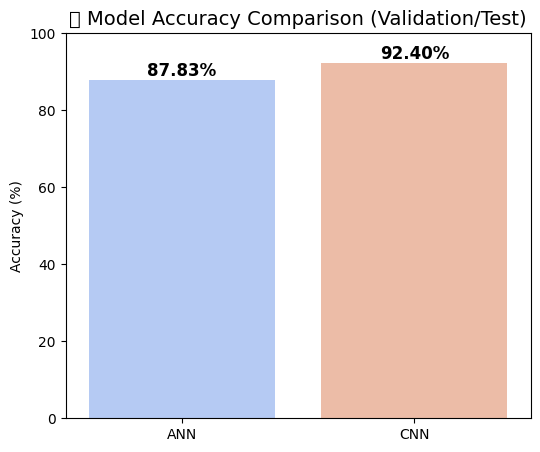


================= PERFORMANCE SUMMARY =================
ANN Test Accuracy: 87.83%
CNN Test Accuracy: 92.40%

CNN typically performs better because it captures spatial features (edges, textures, patterns),
while the ANN only sees flattened pixels without spatial context.
Common confusion often occurs between visually similar classes like 'Shirt' vs 'Coat'.
You can improve results further by:
 - Using Data Augmentation (rotation, flipping, etc.)
 - Adding Dropout or BatchNorm
 - Trying different optimizers (e.g., AdamW)
 - Increasing network depth or filters for CNNs


In [5]:
# ============================================================
# 📘 FASHION-MNIST CLASSIFICATION USING ANN & CNN (PyTorch)
# ============================================================

# ✅ Step 1: Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# ============================================================
# ✅ Step 2: Load and Preprocess Dataset
# ============================================================

# Transform: Normalize pixel values to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load Fashion-MNIST training and test datasets
train_dataset = datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform
)

# Split the training dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for batching and shuffling
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ============================================================
# ✅ Step 3: Visualize Sample Images
# ============================================================

labels_map = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

def show_samples(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    fig, axes = plt.subplots(1, 6, figsize=(12, 3))
    for i in range(6):
        img = images[i].squeeze()
        label = labels_map[labels[i].item()]
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(label)
        axes[i].axis('off')
    plt.suptitle("🔍 Sample Fashion-MNIST Images", fontsize=14)
    plt.show()

show_samples(train_loader)

# ============================================================
# ✅ Step 4: Define the Models
# ============================================================

# --- Model 1: Artificial Neural Network (ANN / MLP) ---
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


# --- Model 2: Convolutional Neural Network (CNN) ---
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)  # ✅ Fixed flatten size
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))  # Output: [batch, 64, 14, 14]
        x = self.dropout(x)
        x = x.view(x.size(0), -1)             # Flatten dynamically
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ============================================================
# ✅ Step 5: Training and Evaluation Functions
# ============================================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        train_losses.append(running_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses


def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return all_labels, all_preds, accuracy

# ============================================================
# ✅ Step 6: Train Both Models
# ============================================================

print("\nTraining ANN Model...")
ann_model = ANN()
ann_train_loss, ann_val_loss = train_model(ann_model, train_loader, val_loader, epochs=10)
ann_labels, ann_preds, ann_acc = test_model(ann_model, test_loader)

print("\nTraining CNN Model...")
cnn_model = CNN()
cnn_train_loss, cnn_val_loss = train_model(cnn_model, train_loader, val_loader, epochs=10)
cnn_labels, cnn_preds, cnn_acc = test_model(cnn_model, test_loader)

# ============================================================
# ✅ Step 7: Confusion Matrices
# ============================================================

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels_map, yticklabels=labels_map)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print("\n📊 ANN Confusion Matrix:")
plot_confusion(ann_labels, ann_preds, "ANN Confusion Matrix")

print("\n📊 CNN Confusion Matrix:")
plot_confusion(cnn_labels, cnn_preds, "CNN Confusion Matrix")

# ============================================================
# ✅ Step 8: Bar Graph Comparison (ANN vs CNN)
# ============================================================

plt.figure(figsize=(6, 5))
models = ['ANN', 'CNN']
accuracies = [ann_acc, cnn_acc]

sns.barplot(x=models, y=accuracies, palette='coolwarm')
plt.title("📈 Model Accuracy Comparison (Validation/Test)", fontsize=14)
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center', fontsize=12, fontweight='bold')
plt.show()

# ============================================================
# ✅ Step 9: Performance Summary
# ============================================================

print("\n================= PERFORMANCE SUMMARY =================")
print(f"ANN Test Accuracy: {ann_acc:.2f}%")
print(f"CNN Test Accuracy: {cnn_acc:.2f}%")
print("\nCNN typically performs better because it captures spatial features (edges, textures, patterns),")
print("while the ANN only sees flattened pixels without spatial context.")
print("Common confusion often occurs between visually similar classes like 'Shirt' vs 'Coat'.")
print("You can improve results further by:")
print(" - Using Data Augmentation (rotation, flipping, etc.)")
print(" - Adding Dropout or BatchNorm")
print(" - Trying different optimizers (e.g., AdamW)")
print(" - Increasing network depth or filters for CNNs")
